In [52]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.stats import proportion
import warnings
%matplotlib inline

In [65]:
def build_tables(pre_df):
    # using this as the only place to pull pre-syn's from because it's well-proofread
    presyn_df = ['allen_v1_column_types_slanted']
    df = client.materialize.query_table(presyn_df[0],split_positions=True)
    # post-synaptic partners of starter cell
    pre_root_id = np.array(pre_df.pt_root_id)[0]
    syn_unfiltered = client.materialize.query_table('synapses_pni_2',
                                                filter_equal_dict={'pre_pt_root_id':pre_root_id})
    # if updated, this will change
    correct_soma_table = client.info.get_datastack_info()['soma_table']
    # x, y, and z will have their own columns
    nuclei_unmasked = client.materialize.query_table(correct_soma_table,split_positions=True)
    # new df of just neurons (no glial cells)
    nuclei = nuclei_unmasked.query('cell_type == "neuron"').reset_index(drop=True)
    # new column saying how many neurons have the same root_id
    nuclei['num_soma'] = nuclei.groupby('pt_root_id').transform('count')['valid']
    # mask the df to throw out merged nuclei (same root_id being assigned to multiple neurons)
    mask_nuclei = nuclei['num_soma'] < 2
    nuclei_full = nuclei[mask_nuclei].reset_index(drop=True)
    # grabbing the unique root_id's of single-body neurons
    unique_nuc = np.unique(nuclei_full.pt_root_id)
    # masking the cell type table for only single-body neurons
    soma_full = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1',
                                               filter_in_dict = {'pt_root_id':unique_nuc},
                                               split_positions=True)
    # masking the synapse table for only single-body neurons. these contain a ton of duplicates
    syn_nuc_dup = syn_unfiltered.query("post_pt_root_id in @unique_nuc").reset_index(drop=True)
    # new column in synapse table = number of synapses per single soma
    syn_nuc_dup['num_syn'] = syn_nuc_dup.groupby('post_pt_root_id').transform('count')['valid']
    syn_nuc_dup = syn_nuc_dup.sort_values(by=['post_pt_root_id']).reset_index(drop=True)
    # renaming bc 'size' is a function and it messes with grouping
    syn_nuc_dup.rename(columns={'size':'sizes'}, inplace=True)
    # dropping duplicates
    syn_nuc = syn_nuc_dup.drop_duplicates(subset='post_pt_root_id', keep='first').reset_index(drop=True)
    # grabbing every synaptic size and position and stacking them into a tuple so that each unique nucleus has a list of syn sizes
    syn_nuc['ctr_pt_position'] = syn_nuc_dup.assign(ctr_pt_position=tuple(syn_nuc_dup.ctr_pt_position)).groupby('post_pt_root_id').ctr_pt_position.apply(list).reset_index(drop=True)
    syn_nuc['sizes'] = syn_nuc_dup.assign(sizes=tuple(syn_nuc_dup.sizes)).groupby('post_pt_root_id').sizes.apply(list).reset_index(drop=True)
    syn_nuc['sum_size'] = syn_nuc.apply(lambda row: sum(row.sizes), axis=1)
    syn_nuc['ave_size'] = syn_nuc.apply(lambda row: row.sum_size / len(row.sizes), axis=1)
    # renaming post_pt_root_id in order to merge correctly
    syn_nuc.rename(columns={'post_pt_root_id':'pt_root_id'}, inplace=True)
    # merge!
    main = pd.merge(soma_full,syn_nuc,on='pt_root_id',how='left')
    # these columns are useless to me
    main = main.drop(columns=['id_x', 'id_y', 'valid_x', 'valid_y', 'pt_supervoxel_id', 'pre_pt_supervoxel_id', 
                          'post_pt_supervoxel_id', 'pre_pt_position', 'post_pt_position'])
    main = main.fillna(0)
    # add new columns for cartesian & radial distance to root_id's 
    main['d'] = Cartdistance_cell2cell(pre_df,main)
    main['r'] = Raddistance_cell2cell(pre_df,main)
    main['d_syn2pre'] = Cartdistance_syn2cell(main,pre_df)
    main['r_syn2pre'] = Raddistance_syn2cell(main,pre_df)
    main['d_syn2post'] = Cartdistance_syn2cell(main,main)
    main['r_syn2post'] = Raddistance_syn2cell(main,main)
    # grabbing the unique root_id's of single-body neurons in the synapse table
    unique_syn_nuc = np.unique(syn_nuc.pt_root_id)
    # new tables sorted from main of synaptic targets or non-synaptic neighbors of pre_root_id
    syn = main.query('pt_root_id in @unique_syn_nuc').reset_index(drop=True)
    nonsyn = main.query('pt_root_id not in @unique_syn_nuc').reset_index(drop=True)
    return main,syn,nonsyn

In [54]:
def class_spitter(df):
    classes = np.unique(df.classification_system)
    cellarray = []
    for i in range(len(classes)):
        new = df.query(f"classification_system in @classes[{i}]").reset_index(drop=True)
        cellarray.append(new)
    return cellarray

def type_spitter(df):
    types = np.unique(df.cell_type)
    cellarray = []
    for i in range(len(types)):
        new = df.query(f"cell_type in @types[{i}]").reset_index(drop=True)
        cellarray.append(new)
    return cellarray

In [55]:
def Cartdistance_cell2cell(pre,post):
    # adjusts coordinates to be in units of microns
    xy = (4./1000)
    z = (40./1000)
    x_pre,y_pre,z_pre = np.array(pre.pt_position_x)*xy,np.array(pre.pt_position_y)*xy,np.array(pre.pt_position_z)*z
    x_pos,y_pos,z_pos = np.array(post.pt_position_x)*xy,np.array(post.pt_position_y)*xy,np.array(post.pt_position_z)*z
    d = np.zeros(len(post))
    for i in range(len(post)):
        d[i] = np.around(np.sqrt((x_pre-x_pos[i])**2 + (y_pre-y_pos[i])**2 + (z_pre-z_pos[i])**2),3)
    return d

def Raddistance_cell2cell(pre,post):
    # adjusts coordinates to be in units of microns
    xy = (4./1000)
    z = (40./1000)
    x_pre,z_pre = np.array(pre.pt_position_x)*xy,np.array(pre.pt_position_z)*z
    x_pos,z_pos = np.array(post.pt_position_x)*xy,np.array(post.pt_position_z)*z
    d = np.zeros(len(post))
    for i in range(len(post)):
        d[i] = np.around(np.sqrt((x_pre-x_pos[i])**2 + (z_pre-z_pos[i])**2),3)
    return d


def Cartdistance_syn2cell(syn_df,cell):
    # adjusts coordinates to be in units of microns
    xy = (4./1000)
    z = (40./1000)
    x_cell,y_cell,z_cell = np.array(cell.pt_position_x)*xy,np.array(cell.pt_position_y)*xy,np.array(cell.pt_position_z)*z
    distance = []
    for i in range(len(syn_df)):
        d = []
        if syn_df.ctr_pt_position[i] == 0:
            d.append(0)
        else:
            for j in range(len(np.array(syn_df.ctr_pt_position[i]))):
                x_syn = np.array(syn_df.ctr_pt_position[i])[j][0]*xy
                y_syn = np.array(syn_df.ctr_pt_position[i])[j][1]*xy
                z_syn = np.array(syn_df.ctr_pt_position[i])[j][2]*z
                if len(cell) == 1:
                    dsyn = np.sqrt((x_syn-x_cell[0])**2 + (y_syn-y_cell[0])**2 + (z_syn-z_cell[0])**2)
                else:
                    dsyn = np.sqrt((x_syn-x_cell[i])**2 + (y_syn-y_cell[i])**2 + (z_syn-z_cell[i])**2)
                d.append(np.around(dsyn,3))
        distance.append(d)
    return distance

def Raddistance_syn2cell(syn_df,cell):
    # adjusts coordinates to be in units of microns
    xy = (4./1000)
    z = (40./1000)
    x_cell,z_cell = np.array(cell.pt_position_x)*xy,np.array(cell.pt_position_z)*z
    distance = []
    for i in range(len(syn_df)):
        d = []
        if syn_df.ctr_pt_position[i] == 0:
            d.append(0)
        else:
            for j in range(len(np.array(syn_df.ctr_pt_position[i]))):
                x_syn = np.array(syn_df.ctr_pt_position[i])[j][0]*xy
                z_syn = np.array(syn_df.ctr_pt_position[i])[j][2]*z
                if len(cell) == 1:
                    dsyn = np.sqrt((x_syn-x_cell[0])**2 + (z_syn-z_cell[0])**2)
                else:
                    dsyn = np.sqrt((x_syn-x_cell[i])**2 + (z_syn-z_cell[i])**2)
                d.append(np.around(dsyn,3))
        distance.append(d)
    return distance

In [56]:
def binomial_CI(df, bins):
    fail = []
    success = []
    # no cells are less than 0 microns away, and this makes sure my arrays are the same size
    fail.append(0)
    success.append(0)
    for i in range(len(bins)-1):
        # masking for specific distance bin
        masked_df = df[(df['r'] < bins[i+1]) & (df['r'] > bins[i])].reset_index(drop=True)
        # starting the counter
        f,s = 0,0
        for j in range(len(masked_df)):
            if masked_df['pre_pt_root_id'][j] == 0:
                f += 1
            else:
                s += 1
        # if there are zero cells in masked_df, 0's are appended
        fail.append(f)
        success.append(s)
    return np.array(fail),np.array(success)

In [57]:
def threepanels_pertype(syn_types,nonsyn_types,pre,s_type,f_type,unique_types,bins,r_interval,filename):
    warnings.filterwarnings('ignore')

    fig, ax = plt.subplots(len(unique_types),3)
    fig.set_size_inches(12,26)

    x = bins-(r_interval/2)
    for i in range(len(unique_types)):
        sns.scatterplot(x=nonsyn_types[i].pt_position_x*(4/1000), y=nonsyn_types[i].pt_position_z*(40/1000), 
                        ax=ax[i,0], color='grey', alpha=.4, s=10)
        sns.scatterplot(x=syn_types[i].pt_position_x*(4/1000), y=syn_types[i].pt_position_z*(40/1000), 
                        ax=ax[i,0], color='b', alpha=.8, s=10).set_xlabel(r'$\mu$m (x vs z)')
        sns.scatterplot(x=pre.pt_position_x*(4/1000), y=pre.pt_position_z*(40/1000), marker='*',color='r',s=200,
                        ax=ax[i,0]).set_ylabel(unique_types[i], fontsize=16)
        xrange = [int(pre.pt_position_x*(4/1000))-250,int(pre.pt_position_x*(4/1000))+250]
        yrange = [int(pre.pt_position_z*(40/1000))-250,int(pre.pt_position_z*(40/1000))+250]
        ax[i,0].set_xlim(xrange[0],xrange[1])
        ax[i,0].set_ylim(yrange[0],yrange[1])
        ax[i,0].set_aspect('equal')

        method = 'wilson'
        errorbars = sm.stats.proportion.proportion_confint(s_type[i],nobs=(s_type[i]+f_type[i]),method=method)
        probability = (s_type[i]/(f_type[i]+s_type[i]))
        ax[i,1].scatter(x=x, y=probability)
        ax[i,1].errorbar(x=x, y=probability, yerr=(probability-errorbars[0],errorbars[1]-probability), fmt='-o') 
        ax[i,1].set_xlabel(r'$\mu$m (radial)', fontsize=10)
        ax[i,1].set_ylabel("Probability of Connection", fontsize=10)
        ax[i,1].set_ylim(-0.1,1.)
        ax[i,1].grid()

        ax[i,2].hist(x,bins=len(bins),weights=f_type[i]+s_type[i],density=False,label='Non-Synaptic', color='grey')
        ax[i,2].hist(x,bins=len(bins),weights=s_type[i],density=False,label='Synaptic', color='blue')
        ax[i,2].set_yscale('log')
        ax[i,2].set_xlabel(r'$\mu$m (radial)', fontsize=10)
        ax[i,2].set_xlim(-10,(max(bins)+10))
        ax[i,2].grid()
        ax[i,2].set_ylabel("Log Frequency", fontsize=10)

    fig.tight_layout()
    fig.savefig('{0:s}.pdf'.format(filename))

### Careful! Read https://annotationframeworkclient.readthedocs.io/en/stable/guide/authentication.html#new-token if this does not work for you!

In [58]:
client = CAVEclient(global_only=True)
client = CAVEclient('minnie65_phase3_v1')

In [59]:
# using this as the only place to pull pre-syn's from because it's well-proofread
presyn_df = ['allen_v1_column_types_slanted']
df = client.materialize.query_table(presyn_df[0],split_positions=True)

Put your pre-synaptic root_id's here...

In [60]:
pre_root_ids = [864691135428608048]
pre = []
for i in range(len(pre_root_ids)):
    pre_grab = df.query(f"pt_root_id == @pre_root_ids[{i}]")
    pre.append(pre_grab)

Or grab from the proofread df!

In [68]:
pre_23P = []
pre_df = df.query("cell_type == '23P'").reset_index(drop=True)
for i in range(len(pre_df)):
    p = pre_df.iloc[[i]]
    pre_23P.append(p)

The following function, `build_tables`, takes only 1 input, and that is one pre-synaptic cell. The function outputs 3 things, all pandas tables containing confirmed single-body somas that have been analyzed by Forrest & Leila and categorized as 1 out of 11 possible subtypes: 

1. `main` table containing all of the above,
2. `syn` table containing only neurons connecting to whichever pre-synaptic cell was given,
3. `nonsyn` table containing only neurons that are NOT connected to the pre-synaptic cell.

All three have their positions split into x,y,z and all have columns corresponding to their Euchlidean and Radial distance from the pre-synaptic cell. In the main table, if their `pre_pt_root_id` equals zero, that means they are not in the post-synaptic table, and not connected to the pre-synaptic root_id.

In [62]:
main,syn,nonsyn = [],[],[]
for i in range(len(pre)):
    m,s,n = build_tables(pre[i])
    main.append(m)
    syn.append(s)
    nonsyn.append(n)

In [63]:
for j in range(len(pre)):
    print("There are {0:d} neuronal post-synaptic connections for cell {1:d}!".format(len(syn[j]),int(pre[j].pt_root_id)))

There are 1718 neuronal post-synaptic connections for cell 864691135428608048!


The following functions will take the tables generated above and split them into class-specific or type-specific tables. 

The tables will be referenced as such: 

- `main_class[0]` will contain two class-specific tables for your first pre-synaptic root_id
- `syn_types[1][3]` will contain a single table of cells of the fourth specific type for your second pre-synaptic root_id, and only contain the ones connected to your pre-syn cell

I personally don't use the class arrays for anything, but I figured I'd include it anyways.

In [32]:
main_class,syn_class,nonsyn_class = [],[],[]
main_types,syn_types,nonsyn_types = [],[],[]
for i in range(len(pre)):
    m_c = class_spitter(main[i])
    s_c = class_spitter(syn[i])
    n_c = class_spitter(nonsyn[i])
    main_class.append(m_c)
    syn_class.append(s_c)
    nonsyn_class.append(n_c)
    
    m_t = type_spitter(main[i])
    s_t = type_spitter(syn[i])
    n_t = type_spitter(nonsyn[i])
    main_types.append(m_t)
    syn_types.append(s_t)
    nonsyn_types.append(n_t)

The following will be used for constructing the confidence interval.
 - `r_interval` is the bin width for each radial ring (in microns)
 - `upper_distance_limit`, again in microns, is the radial distance away from your pre-synaptic cell

In [33]:
r_interval = 25
upper_distance_limit = 400
bins_25 = np.array(range(0,upper_distance_limit,r_interval))

The following function `binomial_CI` takes a table, checks if each cell has a pre-synaptic root_id in a given radial distance, and creates two arrays of bin length:

- `f_type`, containing the number of cells per bin not connected (failure), and 
- `s_type`, containing the number of cells per bin that IS connected (success)

In [34]:
f_type,s_type = [],[]
for i in range(len(pre)):
    ff,ss = [],[]
    for j in range(len(main_types[i])):
        f,s = binomial_CI(main_types[i][j],bins_25)
        ff.append(f)
        ss.append(s)
    f_type.append(ff)
    s_type.append(ss)

Finally, this cell will create a pdf of the 33-panel plot for each pre-synaptic root_id inside of the table `pre`. Arguments are as follows:
1. `syn_types` is the synaptic table split into types
2. `nonsyn_types` is the non-synaptic table, also split into types
3. `pre` is the pre-synaptic table (just one row)
4. `s_type` is any array containing the number of successful connections to single somas per radial distance bin, generated above.
5. `f_type` is any array containing the number of unconnected cells per radial distance bin, generated above.
6. `unique_types` is an array of the unique cell types, generated in the loop below
7. `bins` is the bin array, which will look like [0, 25, 50, 75,...etc] depending on how it was defined in a previous cell
8. `r_interval` is the number of microns in a bin interval, depending on how it was defined in a previous cell
9. `filename` is self-explanatory. Output=pdf. I chose the filename to be the type-hyphen-root_id of the pre-synaptic cell, but feel free to change it.

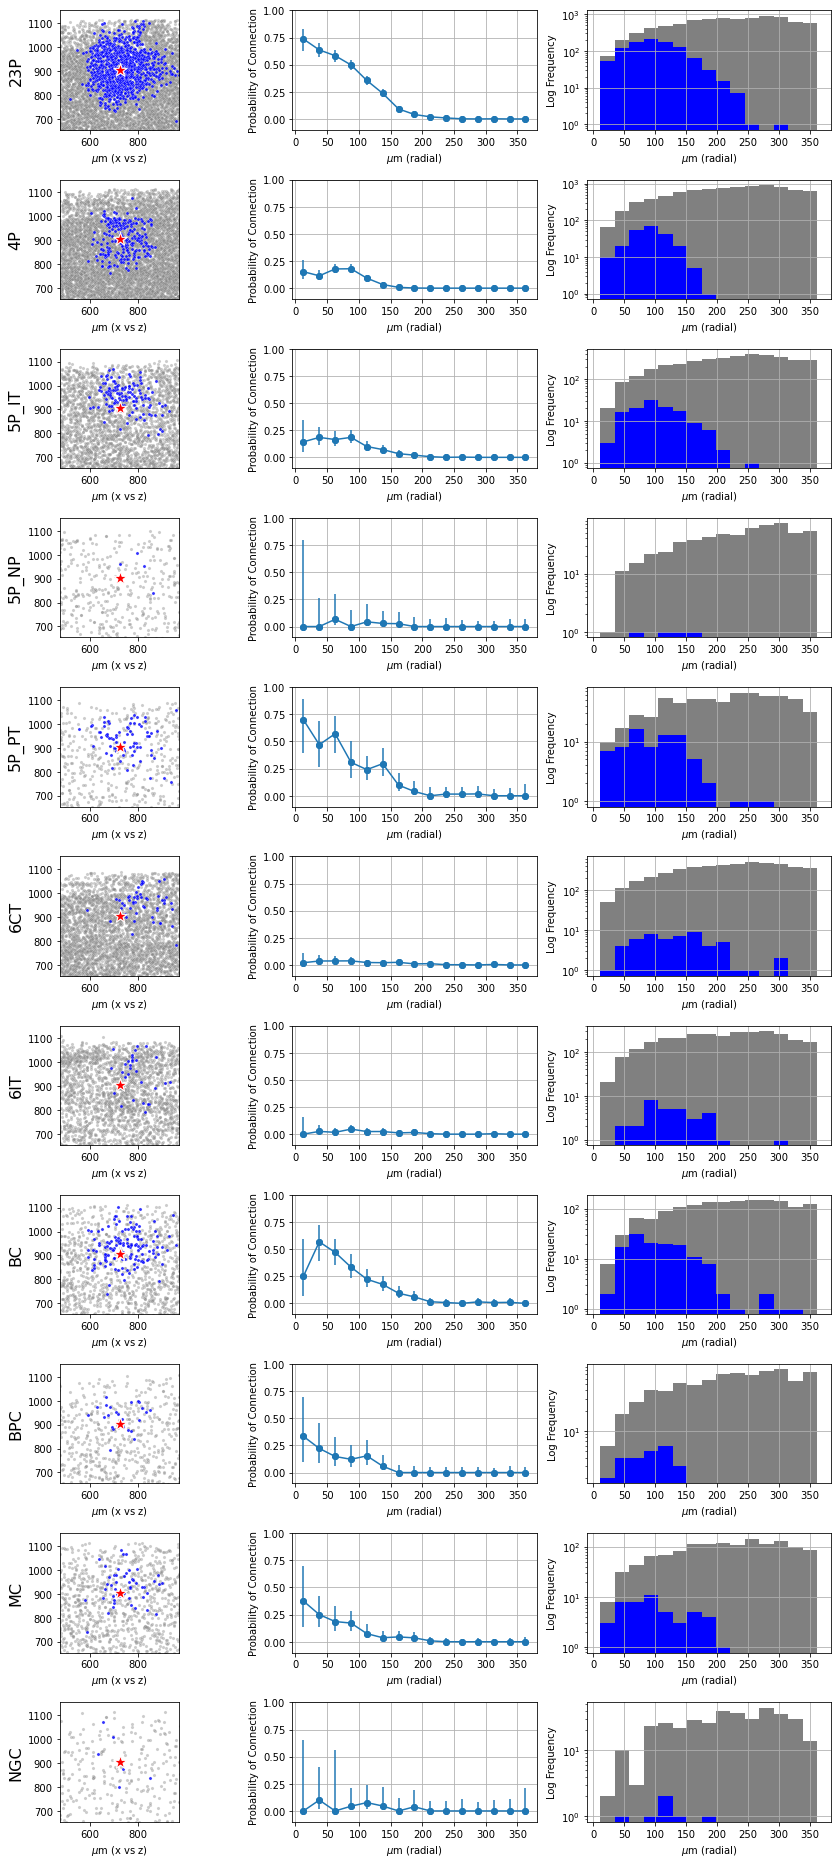

In [35]:
for i in range(len(pre)):
    # this will give filename = 'BC-4587604586048560456748'
    filename = '{0:s}-{1:s}'.format(str(np.array(pre[i].cell_type)[0]),str(np.array(pre[i].pt_root_id)[0]))
    unique_types = np.unique(main[i].cell_type)
    threepanels_pertype(syn_types[i],nonsyn_types[i],pre[i],s_type[i],f_type[i],
                        unique_types,bins_25,r_interval,filename)